# Image classificartion with CNN
<br>Last updated on 10/02/2023</br>
Objective: We aim to classify images into 10 classes of cifar10 dataset using pytorch.

credit : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
! nvidia-smi

Sat Aug 26 06:16:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
transform = transforms.Compose( # transform is from torchvision (only for image)
    [transforms.ToTensor(), # image to tensor --> divide by 255
     transforms.Resize((32, 32))])

batch_size = 32

In [ ]:
torchvision.datasets

<module 'torchvision.datasets' from '/usr/local/lib/python3.10/dist-packages/torchvision/datasets/__init__.py'>

In [ ]:
trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainvalset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 94508458.09it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainset.__len__(), valset.__len__(), testset.__len__()

(40000, 10000, 10000)

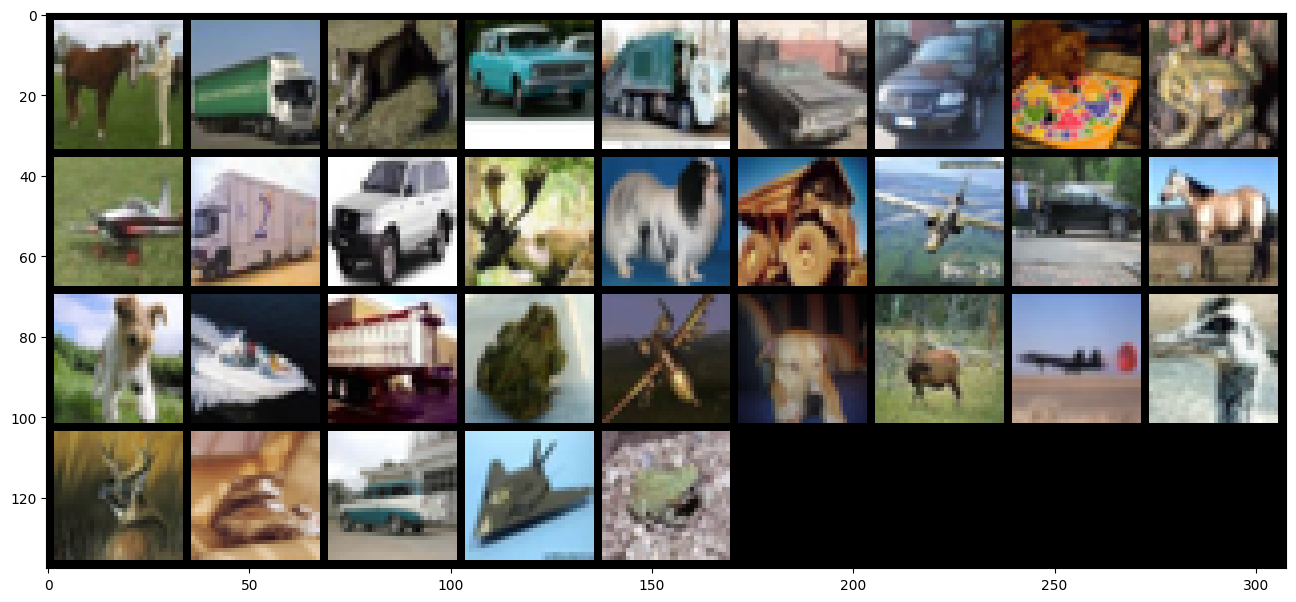

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
nrow = 9
imshow(torchvision.utils.make_grid(images, nrow = nrow))

In [ ]:
# print labels
for i in range(batch_size//nrow + 1 if batch_size % nrow else 0):
  print(' '.join(f'{labels[i*nrow+j]:<3}' for j in range(min(batch_size - i*nrow, nrow))))

7   9   3   1   9   1   1   3   6  
0   9   1   4   5   9   0   1   7  
5   8   9   6   0   5   4   0   2  
4   3   1   0   6  


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5*5 kernel size
        self.pool = nn.MaxPool2d(2, 2) # 2*2 kernel size, 2 strides
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400, 120) # dense input 400 (16*5), output 120

        self.fc2 = nn.Linear(120, 84) # dense input 120, output 84
        self.fc3 = nn.Linear(84, 10) # dense input 84, output 10
        self.softmax = torch.nn.Softmax(dim=1) # perform softmax at dim[1] (batch,class)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,start_dim=1) # flatten all dimensions (dim[1]) except batch (dim[0])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

net = CNN().to(device)

In [ ]:
!pip install torchinfo

In [ ]:
#from torchsummary import summary
#summary(net, (3, 100, 100), batch_size = 32)

from torchinfo import summary as summary_info
print(summary_info(net, input_size = (32, 3, 32, 32))) # (batchsize,channel,width,height)
net = net.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 28, 28]           456
├─MaxPool2d: 1-2                         [32, 6, 14, 14]           --
├─Conv2d: 1-3                            [32, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [32, 16, 5, 5]            --
├─Linear: 1-5                            [32, 120]                 48,120
├─Linear: 1-6                            [32, 84]                  10,164
├─Linear: 1-7                            [32, 10]                  850
├─Softmax: 1-8                           [32, 10]                  --
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 21.06
Input size (MB): 0.39
Forward/backward pass size (MB): 1.67
Params size (MB): 0.25
Estimated Total Size (MB): 2.31


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

epochs = 20

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './CNN_CIFAR10.pth'

for epoch in range(epochs):  # loop over the dataset multiple times

    print(f'epoch {epoch + 1} \nTraining ...')
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    net.train()
    for data in tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # forward
        loss = criterion(outputs, labels) # calculate loss from forward pass
        loss.backward() # just calculate
        optimizer.step() # update weights here

        # aggregate statistics
        training_loss += loss.item()
        n+=1

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    net.eval()
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1

    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss

print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 2.302, acc: 10.02%, f1-score: 2.026%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 2.302, acc: 15.6%, f1-score: 7.586%, support: 10000
epoch 2 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 2.27, acc: 17.13%, f1-score: 12.43%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 2.208, acc: 24.14%, f1-score: 18.74%, support: 10000
epoch 3 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 2.188, acc: 25.61%, f1-score: 23.3%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 2.145, acc: 30.57%, f1-score: 26.0%, support: 10000
epoch 4 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 2.143, acc: 30.88%, f1-score: 29.04%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 2.125, acc: 32.74%, f1-score: 29.06%, support: 10000
epoch 5 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 2.115, acc: 33.87%, f1-score: 31.92%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 2.086, acc: 36.7%, f1-score: 33.99%, support: 10000
epoch 6 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 2.083, acc: 37.28%, f1-score: 35.2%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 2.049, acc: 40.56%, f1-score: 37.77%, support: 10000
epoch 7 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 2.056, acc: 39.86%, f1-score: 37.6%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 2.07, acc: 38.44%, f1-score: 35.62%, support: 10000
epoch 8 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 2.031, acc: 42.45%, f1-score: 40.07%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 2.039, acc: 41.5%, f1-score: 38.21%, support: 10000
epoch 9 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 2.011, acc: 44.53%, f1-score: 42.02%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.987, acc: 46.95%, f1-score: 43.87%, support: 10000
epoch 10 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.998, acc: 45.94%, f1-score: 43.35%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.986, acc: 46.91%, f1-score: 44.44%, support: 10000
epoch 11 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.99, acc: 46.61%, f1-score: 44.07%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.984, acc: 47.17%, f1-score: 44.25%, support: 10000
epoch 12 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.984, acc: 47.26%, f1-score: 44.74%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.984, acc: 47.16%, f1-score: 43.71%, support: 10000
epoch 13 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.977, acc: 47.99%, f1-score: 45.51%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 2.016, acc: 43.93%, f1-score: 40.97%, support: 10000
epoch 14 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.978, acc: 47.91%, f1-score: 45.32%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.997, acc: 45.92%, f1-score: 42.42%, support: 10000
epoch 15 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.967, acc: 49.04%, f1-score: 46.45%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.996, acc: 45.86%, f1-score: 43.63%, support: 10000
epoch 16 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.966, acc: 49.03%, f1-score: 46.32%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.969, acc: 48.67%, f1-score: 45.56%, support: 10000
epoch 17 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.971, acc: 48.7%, f1-score: 46.01%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.975, acc: 48.25%, f1-score: 45.18%, support: 10000
epoch 18 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.968, acc: 48.95%, f1-score: 46.31%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.97, acc: 48.79%, f1-score: 45.8%, support: 10000
epoch 19 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.974, acc: 48.47%, f1-score: 45.98%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.981, acc: 47.8%, f1-score: 45.1%, support: 10000
epoch 20 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.973, acc: 48.54%, f1-score: 45.9%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.994, acc: 46.52%, f1-score: 44.02%, support: 10000
Finished Training


In [ ]:
min_val_loss

1.9692280635285302

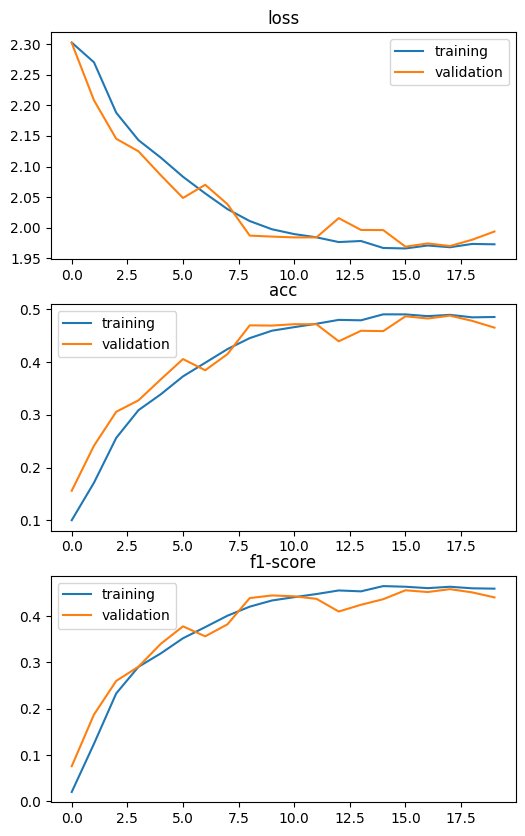

In [ ]:
fig, axs = plt.subplots(3, figsize= (6,10))
# loss
axs[0].plot(history_train['loss'], label = 'training')
axs[0].plot(history_val['loss'], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot(history_train['acc'], label = 'training')
axs[1].plot(history_val['acc'], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()
# f1-score
axs[2].plot(history_train['f1-score'], label = 'training')
axs[2].plot(history_val['f1-score'], label = 'validation')
axs[2].set_title("f1-score")
axs[2].legend()
plt.show()

In [ ]:
net = CNN().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )

    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)
    #acc = report["accuracy"]
    #f1 = report["weighted avg"]["f1-score"]
    #support = report["weighted avg"]["support"]
    #test_loss /= n
    #print(f"validation loss: {test_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )

testing ...


  0%|          | 0/313 [00:00<?, ?it/s]

testing loss: 1.973
              precision    recall  f1-score   support

           0     0.6051    0.4980    0.5464      1000
           1     0.6187    0.6540    0.6359      1000
           2     0.0000    0.0000    0.0000      1000
           3     0.3430    0.2360    0.2796      1000
           4     0.4123    0.3970    0.4045      1000
           5     0.4167    0.4250    0.4208      1000
           6     0.4940    0.6950    0.5775      1000
           7     0.3780    0.7620    0.5053      1000
           8     0.5784    0.6600    0.6165      1000
           9     0.5774    0.5110    0.5422      1000

    accuracy                         0.4838     10000
   macro avg     0.4424    0.4838    0.4529     10000
weighted avg     0.4424    0.4838    0.4529     10000



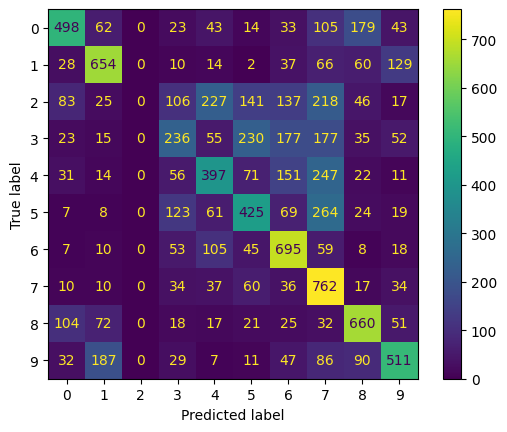

In [ ]:
disp.plot()
plt.show()